In [1]:
import matplotlib.pyplot as plt
import numpy as np

from crazyflow.constants import GRAVITY, MASS
from crazyflow.control import Control
from crazyflow.sim import Sim
from quadcopter_control.controller import QuadcopterController
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm

/home/cwiz/anaconda3/envs/jax/lib/python3.11/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(


In [2]:
# Sim Constants

DT_S = 1./60

DRONE_MASS = 0.027
NEWTON_TO_RPM = 1
FPS = 60

Ixx = 1.4e-5
Iyy = 1.4e-5
Izz = 2.17e-5

MIN_THRUST = 0.26477955 / 4 * 0.8
MAX_THRUST = 0.26477955 / 4 * 1.5

In [3]:
sim = Sim(control=Control.thrust, thrust_freq=100, freq=100)

In [4]:
def reset():
    sim.reset()

In [5]:
def sim_step(motors):
    # change motor order
    motors = np.array([motors[0], motors[2], motors[3], motors[1]])

    # scale
    motors = motors * NEWTON_TO_RPM

    sim.thrust_control(motors.reshape(1, 1, 4))
    sim.step(sim.freq // sim.control_freq)

    position = np.array(sim.data.states.pos.reshape(3))
    velocity = np.array(sim.data.states.vel.reshape(3))
    attitude = R.from_quat(sim.data.states.quat.reshape(4), scalar_first=False)
    omega    = np.array(sim.data.states.ang_vel.reshape(3))


    omega[0], omega[1], omega[2] = -omega[0], -omega[1], omega[2]

    return {
        'position': position,
        'velocity': velocity,
        'attitude': attitude,
        'omega': omega
    }

In [6]:
quadcopter_controller = QuadcopterController(
    DT_S,
    DRONE_MASS * 0.99,
    Ixx, Iyy, Izz,
    0.7, 
    5, 5, 5, 
    0.03,
    MIN_THRUST, MAX_THRUST,
)

In [7]:
def tune_controller(
        target={
            "position": np.array([0, 0, 5]),
            "velocity": np.zeros(3),
            "acceleration": np.zeros(3),
            "attitude": R.from_quat([0, 0, 0, 1]),
        },
        kp_pqr=np.array([95.0, 95.0, 6.0]),
        kp_bank=0.0,
        kp_pos_z=0.0,
        kp_vel_z=0.0,
        ki_pos_z=0.0,
        kp_pos_xy=0.0,
        kp_yaw=0.0,
        kp_vel_xy=0.0,
        kappa=1.0,
        n_episodes=500,
):
    reset()

    quadcopter_controller.integrated_altitude_error = 0.0
    quadcopter_controller.set_gains(
        kp_pqr=kp_pqr,
        kp_bank=kp_bank,
        kp_pos_z=kp_pos_z,
        kp_vel_z=kp_vel_z,
        ki_pos_z=ki_pos_z,
        kp_pos_xy=kp_pos_xy,
        kp_yaw=kp_yaw,
        kp_vel_xy=kp_vel_xy,
        kappa=kappa
    )

    times = []
    positions = []
    attitudes = []
    motors_ = []
    omegas = []

    state = sim_step([0, 0, 0, 0])

    t = 0
    for i in tqdm(range(n_episodes)):

        motors = quadcopter_controller.run_control(
            target['position'],
            target['velocity'],
            target['acceleration'],
            target['attitude'],
            state['position'],
            state['velocity'],
            state['omega'],
            state['attitude'],
        )
        motors_.append(motors)

        # accelerations.append(state['acceleration'])
        attitudes.append(state['attitude'].as_quat())
        positions.append(state['position'])
        omegas.append(state['omega'])
        times.append(t)
        state = sim_step(motors)

        t += DT_S

    return (
        np.array(times),
        np.array(positions),
        np.array(attitudes),
        np.array(omegas),
        np.array(motors_)
    )

In [ ]:
reset()
target = {
    "position": np.array([1, 0, 3]),
    "velocity": np.zeros(3),
    "acceleration": np.zeros(3),
    "attitude": R.from_quat([0, 0, 0, 1]),
}

In [9]:
(times, positions, attitudes, omegas, motors) =  tune_controller(
    kp_pqr=np.array([25, 25, 5]),
    ki_pos_z=2,
    kp_pos_z=6,
    kp_vel_z=12,
    kp_pos_xy=8.0,
    kp_vel_xy=8.0,
    kp_yaw=1.0,
    kp_bank=2.0,
    n_episodes=2500,
    target=target
)

100%|██████████| 2500/2500 [00:03<00:00, 761.96it/s] 


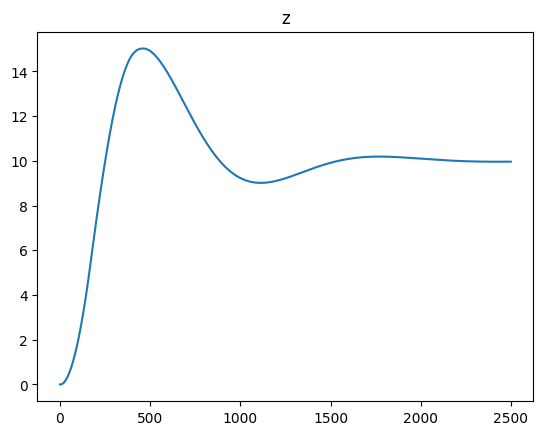

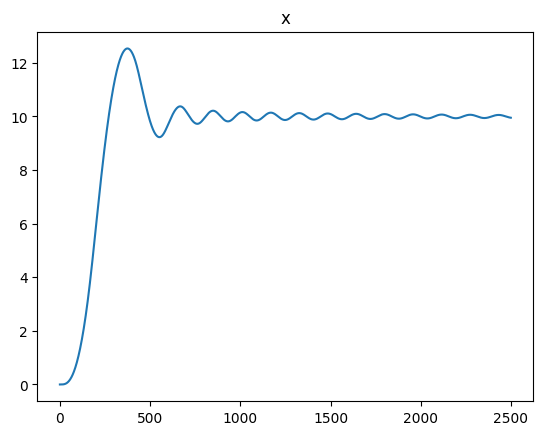

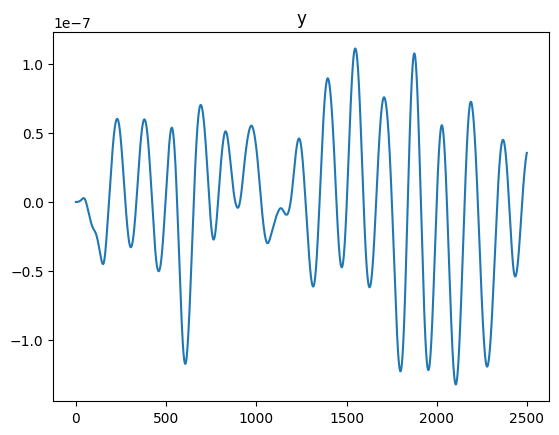

In [10]:
plt.title("z")
plt.plot(positions[:, 2])
plt.show()

plt.title("x")
plt.plot(positions[:, 0])
plt.show()

plt.title("y")
plt.plot(positions[:, 1])
plt.show()

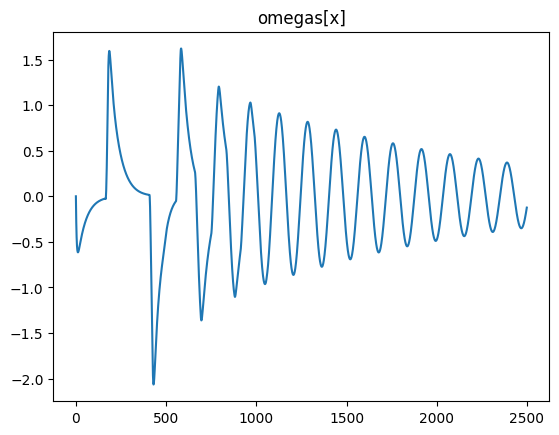

In [11]:
plt.title("omegas[x]")
plt.plot(omegas[:, 1])
plt.show()

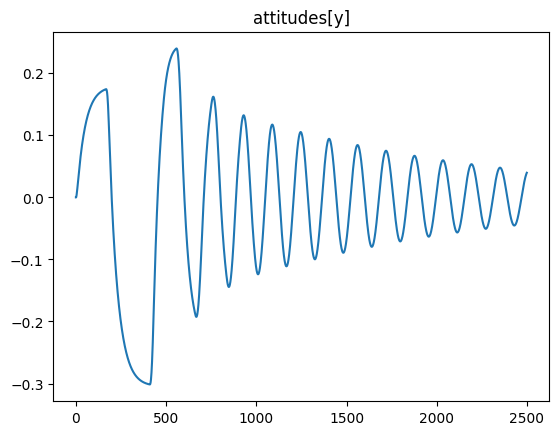

In [12]:
plt.title("attitudes[y]")
plt.plot(attitudes[:, 1])
plt.show()

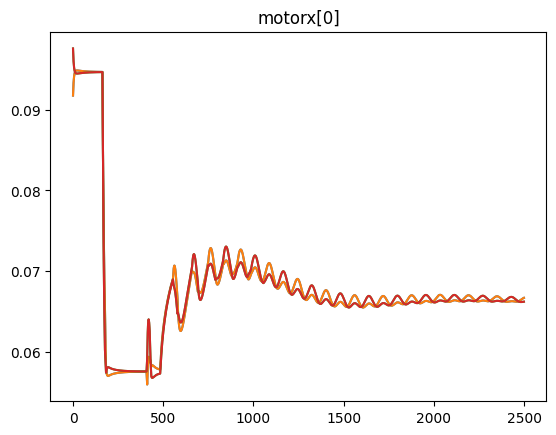

In [13]:
plt.title("motorx[0]")
plt.plot(motors[:, ])
plt.show()